In [1]:
import json
import re
import pandas as pd
import tensorboard as tb
import seaborn as sns; sns.set()
from pathlib import Path
from matplotlib import pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [2]:
class Analyzer:
    def __init__(self, root: str=r'\\aka\work\hara.e\AMED\YOLOX\YOLOX_outputs'):
        self.root = Path(root)
        self.ap_type = {'val/COCOAP50': 'AP50', 'val/COCOAP50_95': 'AP[.5:.95]'}

    def get_scalars(self, path: str=r'amed\events.out.tfevents.1636654538.gpgpu6.2267.0', num_classes: int=1, end: int=None) -> pd.DataFrame:
        path = self.root / path
        data = {'epoch': [], 'AP': [], 'type': [], 'num_classes': []}
        event = EventAccumulator(str(path))
        event.Reload()

        for tag in event.Tags()['scalars']:
            scalars = event.Scalars(tag)
            for scalar in scalars:
                data['epoch'] += [scalar[1]]
                data['AP'] += [scalar[2]]
                data['type'] += [self.ap_type[tag]]
                data['num_classes'] += [str(num_classes)]

        df = pd.DataFrame(data)
        self.df = df[df['epoch'] <= end] if end is not None else df

        return self.df
    
    def get_logs(self, path: str=r'amed', num_classes: int=1, end: int=None):
        path = self.root / path / 'train_log.txt'
        file = pd.read_csv(str(path))
        file = file.drop(file.columns[[0, 1, 2, 3, 4, 5, 7, 8, 11, 12, 13, 14, 15]], axis=1).dropna().set_axis(['iou_loss', 'cls_loss', 'lr'], axis=1).reset_index(drop=True)
        file['iter'] = [i * 10 + 10 for i in range(len(file.index))]
        file['epoch'] = [i // 104 + 1 for i in range(len(file.index))]
        file['iou_loss'] = file['iou_loss'].apply(lambda x: float(re.findall('[0-9]+.+[0-9]?', x)[0]))
        file['cls_loss'] = file['cls_loss'].apply(lambda x: float(re.findall('[0-9]+.+[0-9]?', x)[0]))
        file['lr'] = file['lr'].apply(lambda x: float(re.findall('[0-9]+.+e?\-?[0-9]?', x)[0]))
        file['num_classes'] = [str(num_classes) for _ in range(len(file.index))]
        logs = file[file['epoch'] <= end]

        return logs
    
    def save_df(self, df: pd.DataFrame, out: str):
        path = self.root / out
        df.to_json(path)

In [3]:
analyzer = Analyzer()

In [4]:
one_class = analyzer.get_scalars(r'amed\events.out.tfevents.1636654538.gpgpu6.2267.0', num_classes=1)
four_class = analyzer.get_scalars(r'amed4\events.out.tfevents.1635908171.gpgpu8.352393.0', num_classes=4, end=50)
concated = pd.concat([one_class, four_class]).reset_index(drop=True)

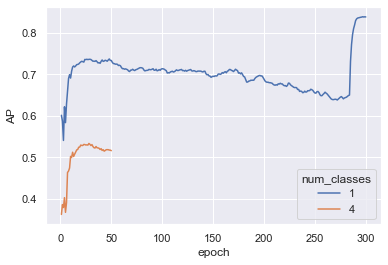

In [5]:
sns.lineplot(data=concated[concated['type'] == 'AP50'], x='epoch', y='AP', hue='num_classes')
plt.savefig('D:/Users/hara.e/Dropbox/ゼミ/AMED/fig/compare_AP50.pdf')

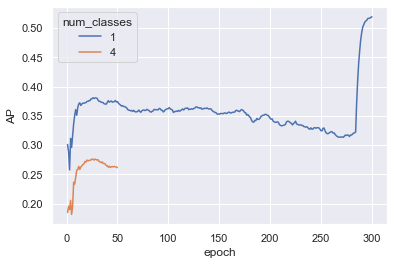

In [6]:
sns.lineplot(data=concated[concated['type'] == 'AP[.5:.95]'], x='epoch', y='AP', hue='num_classes')
plt.savefig('D:/Users/hara.e/Dropbox/ゼミ/AMED/fig/compare_AP.pdf')

In [7]:
logs_one = analyzer.get_logs(r'amed', num_classes=1, end=300)
logs_four = analyzer.get_logs(r'amed4', num_classes=4, end=50)
concated_logs = pd.concat([logs_one, logs_four]).reset_index(drop=True)

D:\Users\hara.e\AppData\Local\Continuum\miniconda3\envs\amed\lib\site-packages\ipykernel_launcher.py:1: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


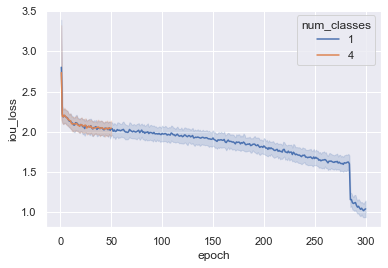

In [8]:
sns.lineplot(data=concated_logs, x='epoch', y='iou_loss', ci='sd', hue='num_classes')
plt.savefig('D:/Users/hara.e/Dropbox/ゼミ/AMED/fig/compare_iou_loss.pdf')

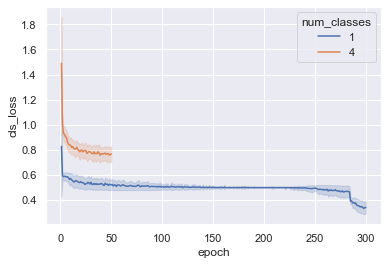

In [9]:
sns.lineplot(data=concated_logs, x='epoch', y='cls_loss', ci='sd', hue='num_classes')
plt.savefig('D:/Users/hara.e/Dropbox/ゼミ/AMED/fig/compare_cls_loss.pdf')

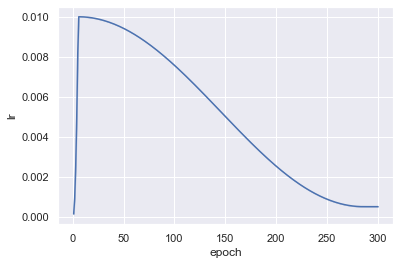

In [10]:
sns.lineplot(data=logs_one, x='epoch', y='lr')
plt.savefig('D:/Users/hara.e/Dropbox/ゼミ/AMED/fig/yoloxs_lr.pdf')

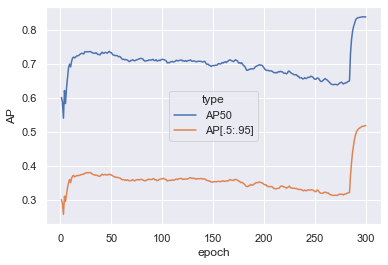

In [11]:
sns.lineplot(data=one_class, x='epoch', y='AP', hue='type')
plt.savefig('D:/Users/hara.e/Dropbox/ゼミ/AMED/fig/yoloxs1_AP.pdf')

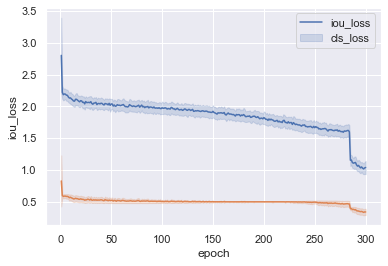

In [12]:
sns.lineplot(data=logs_one, x='epoch', y='iou_loss', ci='sd')
sns.lineplot(data=logs_one, x='epoch', y='cls_loss', ci='sd')
plt.legend(['iou_loss', 'cls_loss'])
plt.savefig('D:/Users/hara.e/Dropbox/ゼミ/AMED/fig/yoloxs1_loss.pdf')

In [13]:
ap50 = one_class[one_class['type'] == 'AP50']
ap = one_class[one_class['type'] == 'AP[.5:.95]']

In [14]:
ap.max()

epoch                 300
AP               0.519393
type           AP[.5:.95]
num_classes             1
dtype: object